# Demand forecasting for taxi order service

## Introduction

**Target of analysis** is to forecast a number of taxi orders for the next hour. Historical data of taxi orders to the airport is provided by taxi order service company. The company plans to use machine learning model to engage more drivers during peak periods.

Model's target metric: RMSE should be no more than 48 orders.

*Table of contents:*
- [data collection](#familiar)
- [exploratory data analysis](#analysis)
- [models' training and evaluation](#learning)
- [testing model](#testing)
- [summary](#conclusion)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

In [6]:
RANDOM_STATE = 1
TEST_SIZE = 0.1

<a id='familiar'></a>

## 1. Data collection

Start with importing data and defining datetime as an index. Then proceed by studying main information about data frame.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [12]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [13]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


The data frame contains about 26 thousand objects with `num_orders` as a target feature (meaning the number of taxi orders).

Ordering information is presented with 10-minute intervals. There are no missing values.
Proceed by checking whether date and time are sorted in ascending order.

In [15]:
data.index.is_monotonic_increasing

True

Continue by data resampling into new interval of 1 hour.

In [17]:
data = data.resample('1H').sum()
data.shape

(4416, 1)

**Intermediate conclusion:** datetime was set as an index and data was resampled with a new interval of 1 hour.

<a id='analysis'></a>

## 2. Exploratory data analysis

Start by checking resampled time series for trend and seasonality.

In [22]:
decomposed = seasonal_decompose(data, model='additive')

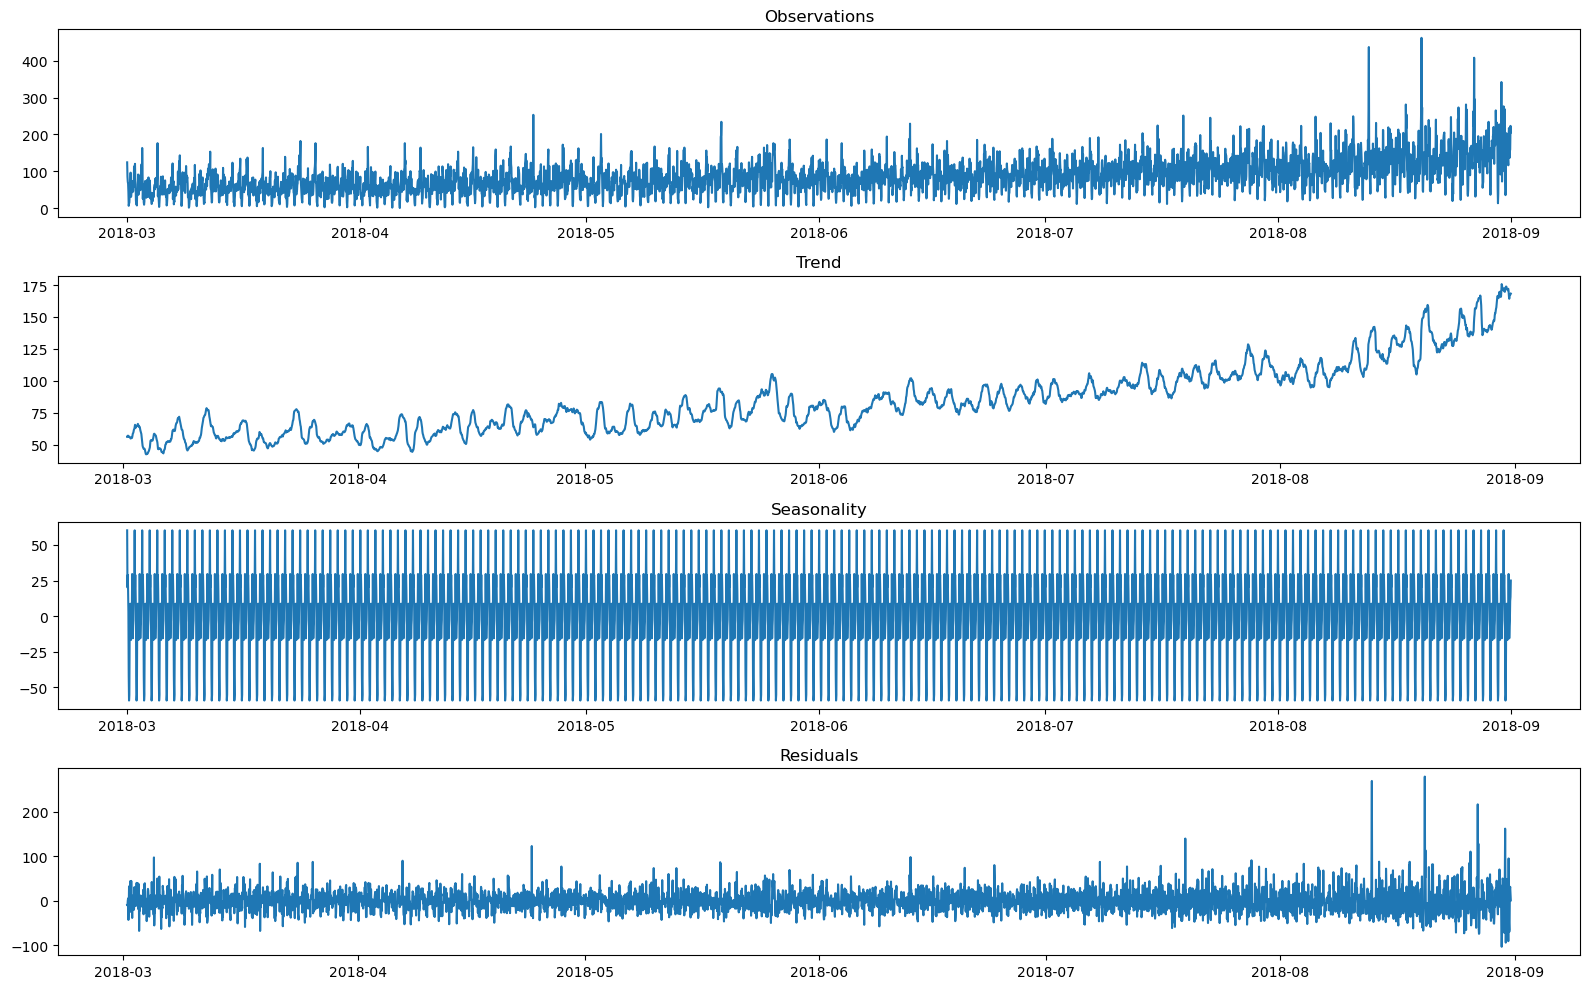

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(16, 10))
axes[0].plot(decomposed.observed)
axes[0].set_title('Observations')
axes[1].plot(decomposed.trend)
axes[1].set_title('Trend')
axes[2].plot(decomposed.seasonal)
axes[2].set_title('Seasonality')
axes[3].plot(decomposed.resid)
axes[3].set_title('Residuals')
plt.tight_layout();

The second plot demonstrates increasing trend throughout entire historical period. The seasonality plot looks quite crowded, so for better visual clarity we would draw separate seasonality plots with smaller time intervals - for last month, week and two days.

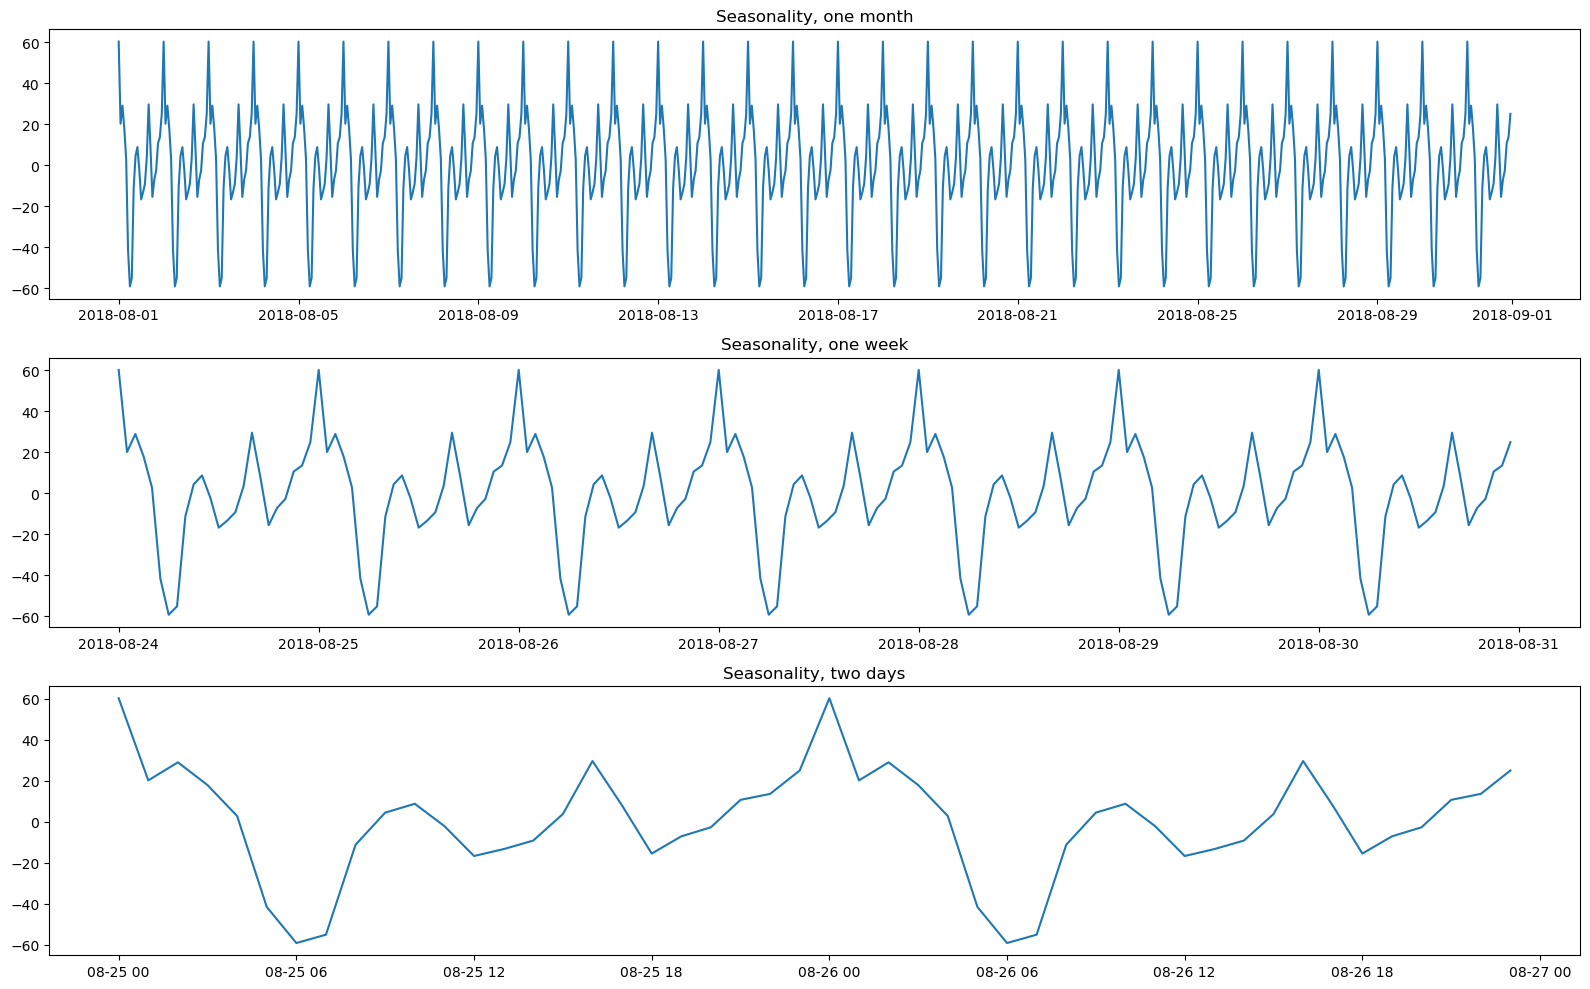

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
axes[0].plot(decomposed.seasonal['2018-08-01':'2018-08-31'])
axes[0].set_title('Seasonality, one month')
axes[1].plot(decomposed.seasonal['2018-08-24':'2018-08-30'])
axes[1].set_title('Seasonality, one week')
axes[2].plot(decomposed.seasonal['2018-08-25':'2018-08-26'])
axes[2].set_title('Seasonality, two days')
plt.tight_layout();

Smaller time interval shows that number of orders decreases at 6 am, increases at 4 pm and then at 12 midnight. The plot shows repeating pattern every 24 hours.

Proceed by applying a rolling mean to the data.

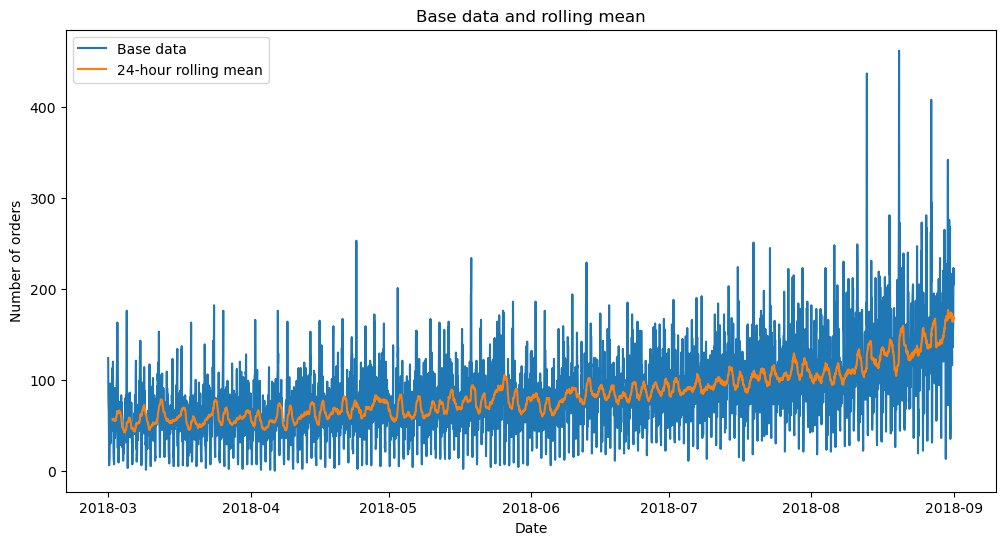

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='Base data')
rolling_mean = data.rolling(24).mean()
plt.plot(rolling_mean, label='24-hour rolling mean')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Base data and rolling mean')
plt.legend()
plt.show();

Continue by taking a closer look at the rolling mean chart for the last month.

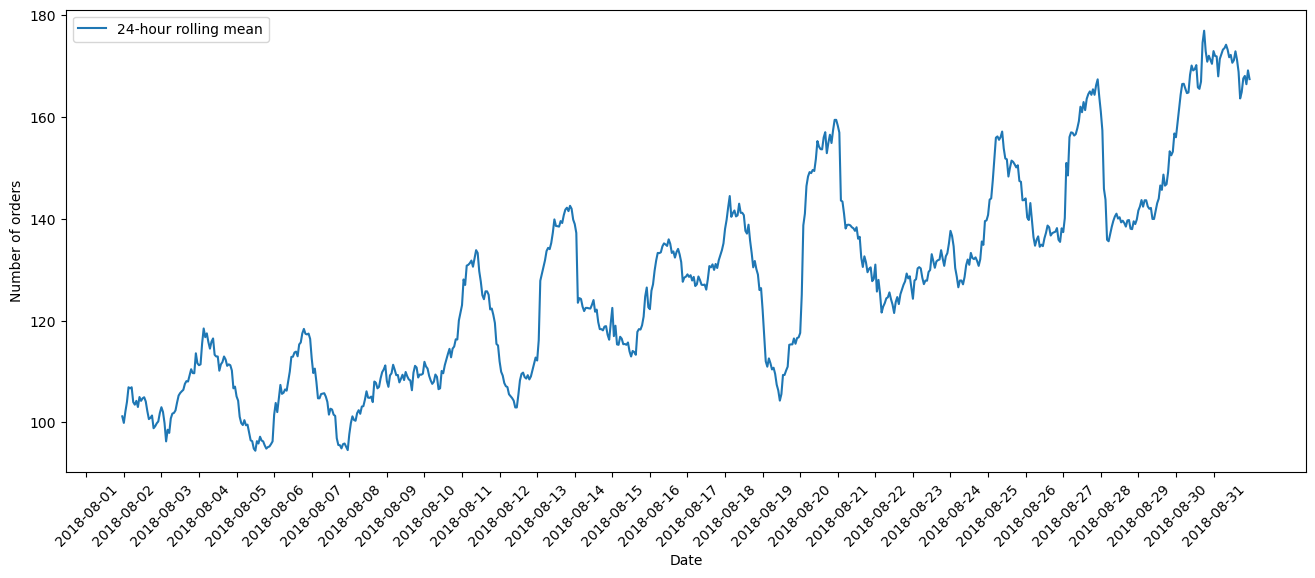

In [29]:
plt.figure(figsize=(16, 6))
rolling_mean = data['2018-08-01':'2018-08-31'].rolling(24).mean()
plt.plot(rolling_mean, label='24-hour rolling mean')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.xticks(data['2018-08-01':'2018-08-31'].index[::24], rotation=45);

The rolling mean chart clearly shows that during the days from 12th to 13th, 19th to 20th and 26th to 27th there were sharp spikes, as well as sharp drops afterwords. August 12th, 19th and 26th are Sundays. Seasonality during a week could be assumed, since the number of orders increases on Sunday.

Presence of a visible trend and seasonality means that time series is non-stationary. We would try to prove this statement using Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests.

Null hypothesis in the Dickey-Fuller test is that the time series is non-stationary.
An alternative hypothesis is that the time series is stationary.

In [31]:
def adfuller_test(df):
    """Carry out the Dickey-Fuller test."""
    df_test_result = adfuller(df)
    print(f'p-value: {df_test_result[1]} \n')

    if df_test_result[1] <= 0.05:
        print('The null hypothesis could be rejected. Apparently, the series is stationary')
    else:
        print('The null hypothesis is failed to be rejected. Apparently, the series is non-stationary')

In [32]:
adfuller_test(data)

p-value: 0.02894005140261486 

The null hypothesis could be rejected. Apparently, the series is stationary


Resulting p-value is less than statistical significance level. Proceed by carrying the Kwiatkowski-Phillips-Schmidt-Shin test, formulating null and alternative hypotheses in reverse. The null hypothesis saying that the time series is stationary. An alternative hypothesis is that the time series is non-stationary.

In [34]:
def kpss_test(df):
    """Carry out the Kwiatkowski-Phillips-Schmidt-Shin test."""
    kpss_test_result = kpss(df)
    print(f'p-value: {kpss_test_result[1]} \n')

    if kpss_test_result[1] <= 0.05:
        print('The null hypothesis could be rejected. Apparently, the series is non-stationary')
    else:
        print('The null hypothesis is failed to be rejected. Apparently, the series is stationary')

In [35]:
kpss_test(data)

p-value: 0.01 

The null hypothesis could be rejected. Apparently, the series is non-stationary


Tests provided two quite conflicting results. It is worth noting that the second test is more sensitive to deterministic trends. And plots clearly demonstrate the presence of trend and seasonality, which means we could say that time series is not completely stationary.

Continue by drawing plots for autocorrelation and partial autocorrelation functions.

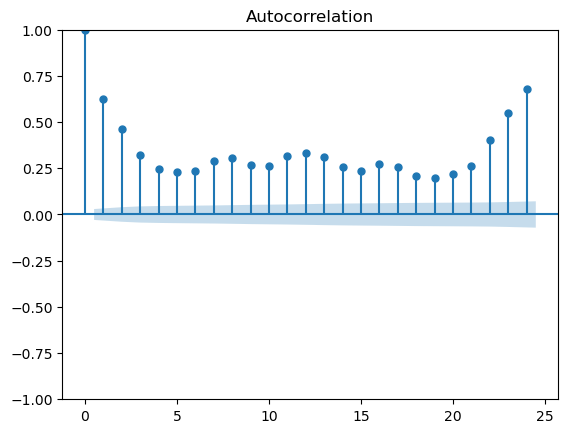

In [37]:
plot_acf(data, lags=24);

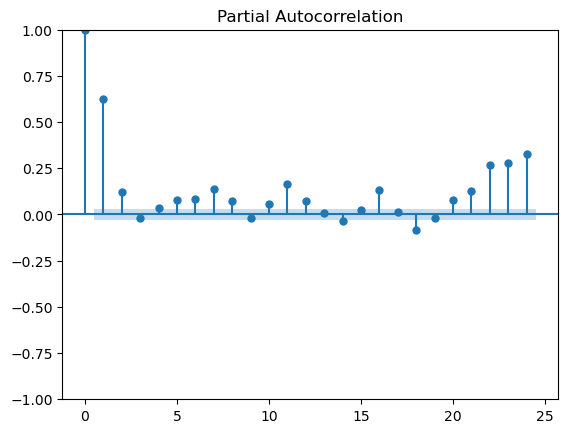

In [38]:
plot_pacf(data, lags=24);

The autocorrelation plot being positive confirms the presence of a trend. 24-hour lag is more strongly correlated with the original series than neighboring 23-hour lag. Сorrelation values are statistically significant, since they fall outside confidence interval.

Since there is seasonality, further we would also train the SARIMA model. To select model's parameters we would draw plots of autocorrelation and partial autocorrelation for time series difference with 1-hour shift.

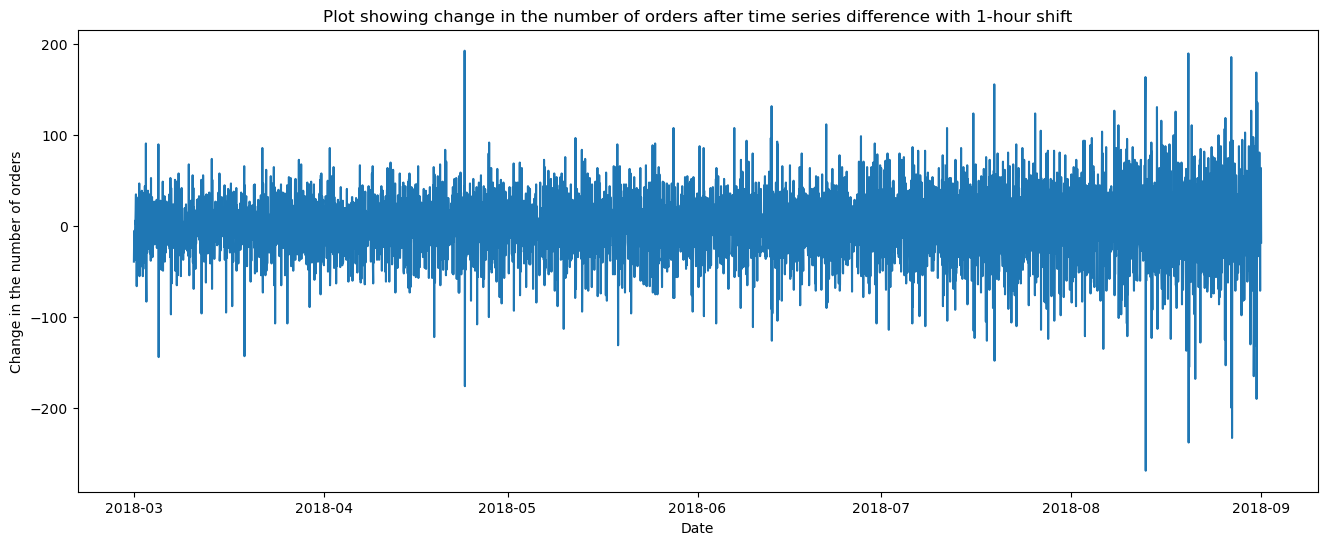

In [40]:
diff_data_1 = data.diff(1).dropna()
plt.figure(figsize=(16, 6))
plt.xlabel('Date')
plt.ylabel('Change in the number of orders')
plt.title('Plot showing change in the number of orders after time series difference with 1-hour shift')
plt.plot(diff_data_1);

1-hour shift removed trend from data and time series' average has become more constant. Continue with carrying stationarity tests.

In [42]:
adfuller_test(diff_data_1)

p-value: 1.0958776746505463e-28 

The null hypothesis could be rejected. Apparently, the series is stationary


In [43]:
kpss_test(diff_data_1)

p-value: 0.1 

The null hypothesis is failed to be rejected. Apparently, the series is stationary


Tests indicate that data is stationary now. This means that parameter `d` for the SARIMA model could be considered equal to 1. Proceed with drawing autocorrelation plots to select other parameters.

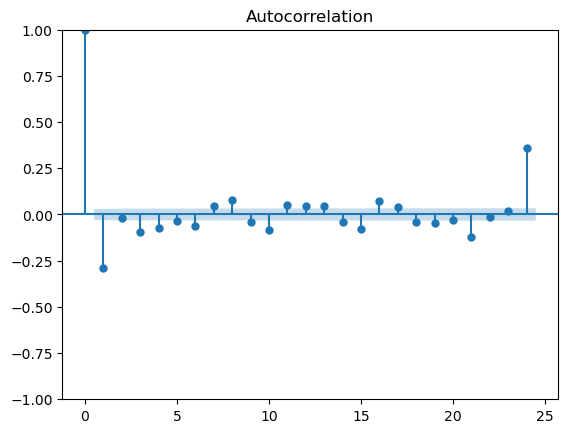

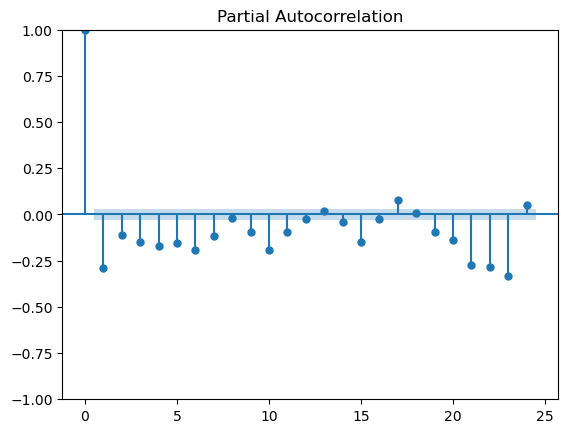

In [45]:
plot_acf(diff_data_1, lags=24)
plot_pacf(diff_data_1, lags=24);

Parameter `p` is determined based on PACF plot as a maximum lag, distinct from 0. We would take it equal to 1 (also due to the fact that model with big parameters would take a long time to train). The parameter `q` is determined according to ACF plot as a number of lags distinct from 0. We would define the parameter `q` equal to 2.

Now we would do the same using a 24-hour shift, due to the obvious presence of 24-hour seasonality.

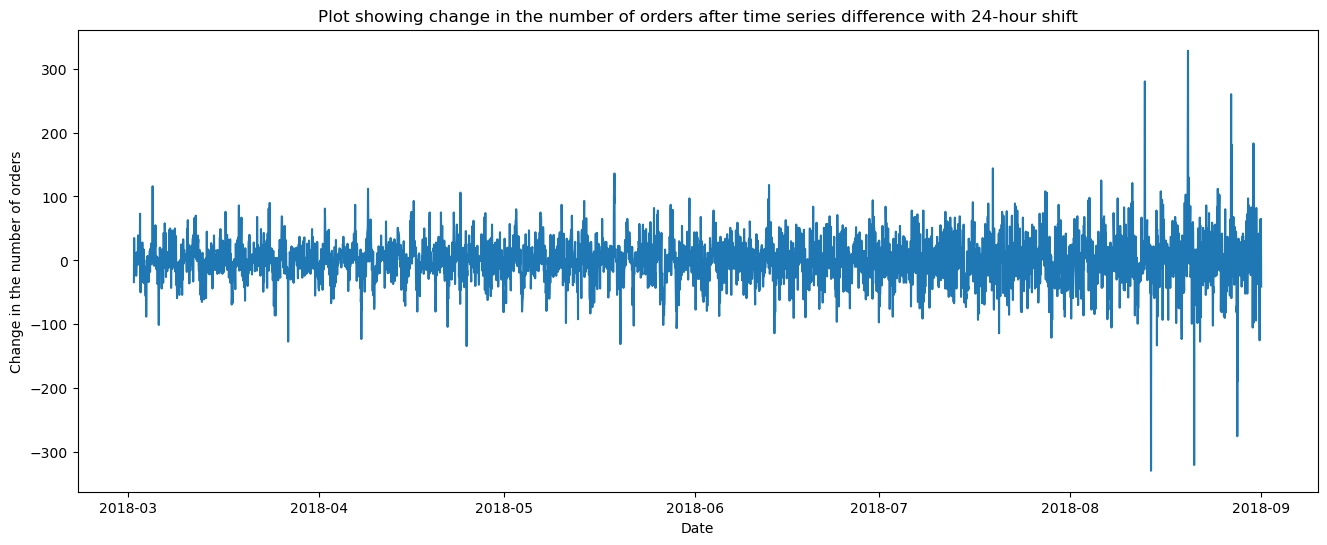

In [47]:
diff_data = data.diff(24).dropna()
plt.figure(figsize=(16, 6))
plt.plot(diff_data)
plt.xlabel('Date')
plt.ylabel('Change in the number of orders')
plt.title('Plot showing change in the number of orders after time series difference with 24-hour shift')
plt.show();

24-hour shift visually makes plot more stationary than 1-hour shift. Proceed with stationarity tests on transformed data.

In [49]:
adfuller_test(diff_data)

p-value: 6.430826940726593e-29 

The null hypothesis could be rejected. Apparently, the series is stationary


In [50]:
kpss_test(diff_data)

p-value: 0.1 

The null hypothesis is failed to be rejected. Apparently, the series is stationary


Both tests indicate that time series has become stationary.

Continue with drawing new plots for autocorrelation and partial autocorrelation functions.

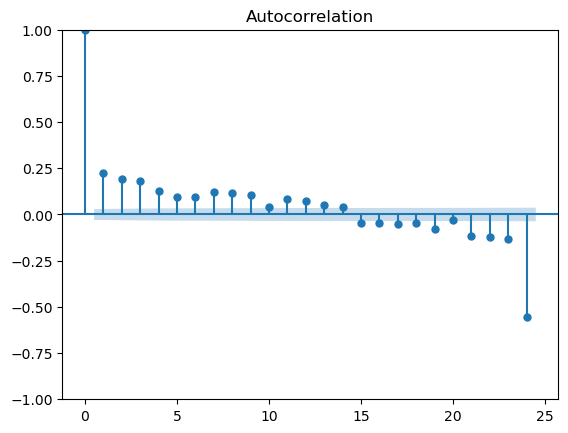

In [52]:
plot_acf(diff_data, lags=24);

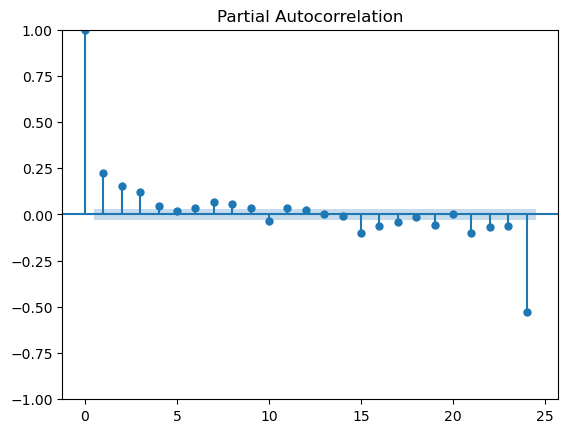

In [53]:
plot_pacf(diff_data, lags=24);

Since only one data transformation has been needed, we would take parameter `D` for the SARIMA model equal to 1. We determine parameter `P` equal to 0 (also due to the fact that model with big parameters would take a long time to train). The parameter `Q` is determined by ACF model equal to 1. The parameter `s` is 24, since the data has 24-hour seasonality. Now we would add features to the time series before models' training.

The SARIMA model would subsequently be trained on the original (resampled data) without reduction to stationarity and additional features. The model would achieve stationarity on its own using the passed parameters. But we would train remaining models on stationary data using a 24-hour shift.

The analysis found that orders are influenced by such factors as time and day of week, and there is seasonality every 24 hours. Therefore, we would add features `day`, `day_of_week`, `hour`. We would also add 24-hour lagging values and a moving average. We carried out an enumeration of potential window size and the most optimal seems to be equal to 7 to save patterns and simultaneously get rid of noise.

In [56]:
data_sarima = data.copy()

In [57]:
def make_features(data, lag, rolling_mean_size):
    """Add features to time series."""
    fit_data = data.copy()
    fit_data['day'] = fit_data.index.day
    fit_data['day_of_week'] = fit_data.index.dayofweek
    fit_data['hour'] = fit_data.index.hour
    
    fit_data['lag_{}'.format(lag)] = fit_data['num_orders'].shift(lag)
    fit_data['rolling_mean'] = fit_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return fit_data

In [58]:
fit_data = make_features(diff_data, 24, 7)

We need to check that changes have been successfully implemented.

In [60]:
fit_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   float64
 1   day           4392 non-null   int32  
 2   day_of_week   4392 non-null   int32  
 3   hour          4392 non-null   int32  
 4   lag_24        4368 non-null   float64
 5   rolling_mean  4385 non-null   float64
dtypes: float64(3), int32(3)
memory usage: 188.7 KB


**Intermediate conclusion:** initial data contained a trend and seasonality, so the time series was not strictly stationary. Analysis showed intraday patterns, 24-hour patterns, and the increase in the number of orders on Sunday. To get rid of non-stationarity time series difference was applied. Also we added additional features for models' training.

<a id='learning'></a>

## 3. Models' training and evaluation

Proceed by splitting data frame into train and test sets.

In [65]:
train, test = train_test_split(fit_data, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In order to prevent target leakage we would remove number of rows equal to the shift from test data.

In [67]:
features_test = features_test[24:]
target_test = target_test[24:]

We would use TimeSeriesSplit to prevent mixing of dates as a part of cross-validation.

In [69]:
def find_best_model(model, param_grid):
    """Select hyperparameters and calculate RMSE."""
    ts = TimeSeriesSplit()
    grid_search = GridSearchCV(model, param_grid, cv=ts, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)
    best_params = grid_search.best_params_
    best_rmse = -1 * grid_search.best_score_
    print(f'Model with the best hyperparameters: {grid_search.best_estimator_} \n'
          f'RMSE: {best_rmse:.5f} \n'
         )
    return grid_search.best_estimator_

We would start with decision tree model.

In [71]:
dtr_model = find_best_model(DecisionTreeRegressor(),
                            param_grid = {'max_depth': range(1, 11), 'random_state': [RANDOM_STATE]}
                           )

Model with the best hyperparameters: DecisionTreeRegressor(max_depth=4, random_state=1) 
RMSE: 26.65458 



The model's best result is with tree's depth equal to 4. RMSE on the training set is 27 orders.

Proceed with linear models, including models with regularization.

In [73]:
lr_model = find_best_model(LinearRegression(), param_grid = {})

Model with the best hyperparameters: LinearRegression() 
RMSE: 26.18245 



In [74]:
lasso_model = find_best_model(Lasso(),
                              param_grid={
                                          'alpha': np.arange(0.1, 1, 0.1),
                                          'random_state': [RANDOM_STATE]})

Model with the best hyperparameters: Lasso(alpha=0.9, random_state=1) 
RMSE: 26.18045 



In [75]:
ridge_model = find_best_model(Ridge(),
                              param_grid={'alpha': np.arange(0.1, 1, 0.1), 'random_state': [RANDOM_STATE]})

Model with the best hyperparameters: Ridge(alpha=0.9, random_state=1) 
RMSE: 26.18245 



In [76]:
elastic_net_model = find_best_model(ElasticNet(),
                                   param_grid={'alpha': np.arange(0.1, 1, 0.1), 'random_state': [RANDOM_STATE]})

Model with the best hyperparameters: ElasticNet(alpha=0.8, random_state=1) 
RMSE: 26.18048 



All linear models shows the same result with RMSE equal to 27 orders.

Here and after models' hyperparameters would be limited in cells to this models' best results to speed up evaluation.

In [78]:
rfr_model = find_best_model(RandomForestRegressor(),
                            param_grid = {'n_estimators': range(9, 10),
                                          'max_depth': range(6, 7),
                                          'random_state': [RANDOM_STATE]}
                           )

Model with the best hyperparameters: RandomForestRegressor(max_depth=6, n_estimators=9, random_state=1) 
RMSE: 25.74714 



RMSE is 26 orders on the training set, which is better than previous results.

Continue with gradient boosting model.

In [80]:
lgbm_model = find_best_model(LGBMRegressor(),
                             param_grid = {
                                 'n_estimators': range(10, 11),
                                 'max_depth': range(9, 10),
                                 'random_state': [RANDOM_STATE],
                                 'verbose': [-1],
                             }
                            )

Model with the best hyperparameters: LGBMRegressor(max_depth=9, n_estimators=10, random_state=1, verbose=-1) 
RMSE: 26.51791 



RMSE in the gradient boosting model is also 27 orders.

In order to proceed with the SARIMA model, we would split the data into training and test sets.

In [82]:
train_sarima, test_sarima = train_test_split(data_sarima,
                                             shuffle=False,
                                             test_size=TEST_SIZE,
                                             random_state=RANDOM_STATE)

In [83]:
sarima_model = SARIMAX(train_sarima, order=(1, 1, 2), seasonal_order=(0, 1, 1, 24)).fit(disp=False)

sarima_train_predictions = sarima_model.predict(train_sarima.index[0], train_sarima.index[-1])
root_mean_squared_error(train_sarima, sarima_train_predictions)

22.02988744754513

The SARIMA model shows the best result among other models, RMSE is only 23 orders on the training data.

**Intermediate conclusion:** the SARIMA model showed best result on the training data, RMSE equals to 23 orders.

<a id='testing'></a>

## 4. Testing model

Start with testing the SARIMA model as the best model.

In [89]:
sarima_predictions = sarima_model.forecast(steps=len(test_sarima))
root_mean_squared_error(test_sarima, sarima_predictions)

44.499214511711656

The SARIMA model demonstrated excellent results on the test data. The result is sufficient to customer's requirement - RMSE is no more than 48 orders.
Continue with drawing a plot of actual and predicted data.

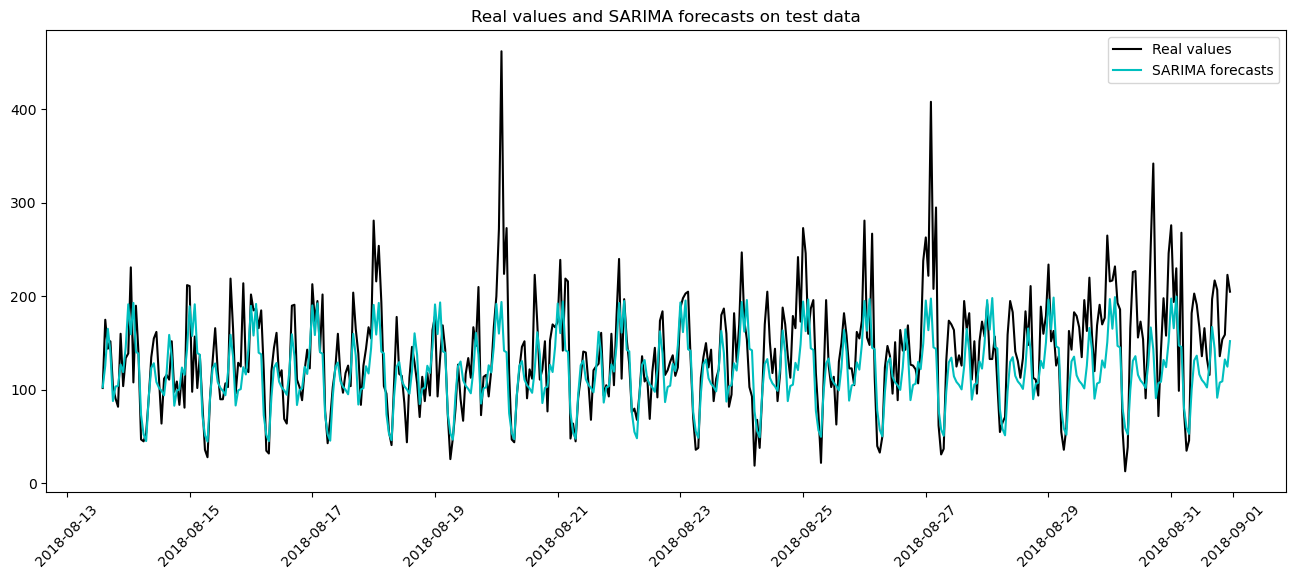

In [91]:
plt.figure(figsize=(16, 6))
plt.plot(test_sarima, 'k-', label='Real values')
plt.plot(sarima_predictions, 'c-', label='SARIMA forecasts')
plt.legend()
plt.title('Real values and SARIMA forecasts on test data')
plt.xticks(rotation=45);

The plot shows that model has noticed the pattern and due to the seasonality demonstrates a good metric.

Proceed by comparing the SARIMA with constant model predicting the next value equal to the current one. In order to do this we would add a column with orders shifted by 1-hour interval and calculate RMSE.

In [94]:
diff_data['naive_model'] = diff_data['num_orders'].shift(1).dropna()
train, test = train_test_split(diff_data, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
root_mean_squared_error(test['num_orders'], test['naive_model'])

73.84629306877902

Naive model's result is worse and doesn't meet the level of customer's requirements.

**Intermediate conclusion:** the SARIMA model's RMSE is 45 orders on the test data, which meets customer's requirement.

<a id='conclusion'></a>

## Summary

**The target of analysis** was to predict a number of taxi orders for the next hour. The client company plans to use model's forecasts to engage more drivers during peak periods. The client expected RMSE to be no more than 48 orders.

During analysis the data was resampled, converted to a stationary form, and new features were added based on the discovered patterns. Eight models were trained and analyzed, including the gradient boosting model and the SARIMA model with a seasonal component.

**Conclusions:**
- the SARIMA model showed the best result with *RMSE* equals to 45 orders on the test data
- the SARIMA model demonstrated better results than a naive model that predicts a future value based on the current one
- depending on the customer’s needs in model's learning speed and prediction, another model could also be set with required metric's threshold